# Regressions

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, LinearRegression
from scipy.stats import skew
from sklearn import decomposition
import math

plt.style.use('ggplot')

On this step we use the train set to fit severl linear models.

In [69]:
# Load the train set
df = pd.read_csv('./data/new_train.csv')
df.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))

df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,RoofMatl_WdShngl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,0,1,0,0,1,0,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,1,0,0,0,0,0,0,1
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,0,1,0,0,0,0,1
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,0,0,0,1,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,1,0,0,0,0,0,0,1


## SalePrice vs. Log Sale Price

For regression models we choose whether to use the sales prices or the log of them. Let's look at the distribution of the prices in our dataset.

    price  log(price)
0  208500   12.247694
1  181500   12.109011
2  223500   12.317167
3  140000   11.849398
4  250000   12.429216


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f102f4bca90>,
      dtype=object)

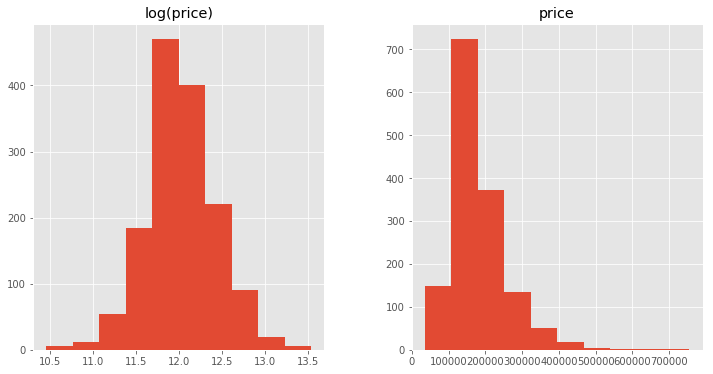

In [64]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df["SalePrice"], "log(price)":np.log(df["SalePrice"])})
print (prices.head())
prices.hist()

It seems that the prices follow the lognormal distribution. Therefore, we will use log of prices as our response variable.

To illustrate it we plot scatter plots of Sales Price and Living Area

Text(0.5,1,'Price')

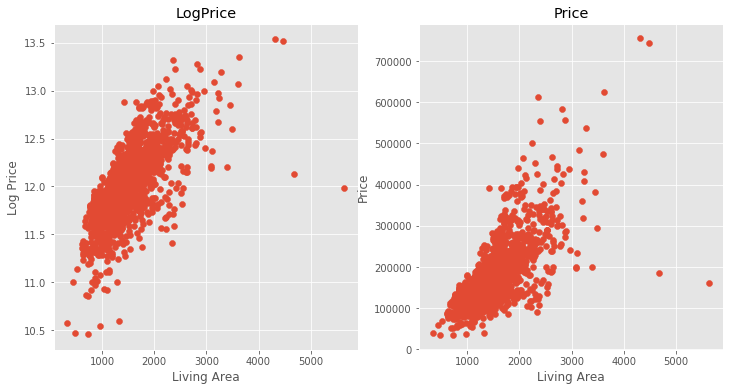

In [65]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df["SalePrice"], "log(price)":np.log(df["SalePrice"])})
prices = prices.join(pd.DataFrame({'LivingArea':df.GrLivArea}))

plt.subplot(1,2,1)
plt.scatter(prices['LivingArea'], prices['log(price)'])
plt.ylabel('Log Price')
plt.xlabel('Living Area')
plt.title('LogPrice')

plt.subplot(1,2,2)
plt.scatter(prices['LivingArea'], prices['price'])
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.title('Price')

We also notice that two houses have an extremely large area with relatively low price. We remove them as outliers

In [66]:
df = df.loc[(df.GrLivArea<4000) & (df.SalePrice<700000),:]

Text(0.5,1,'Price')

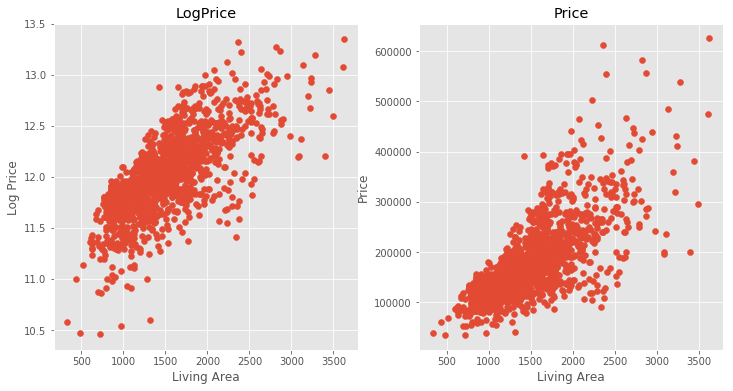

In [67]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df["SalePrice"], "log(price)":np.log(df["SalePrice"])})
prices = prices.join(pd.DataFrame({'LivingArea':df.GrLivArea}))

plt.subplot(1,2,1)
plt.scatter(prices['LivingArea'], prices['log(price)'])
plt.ylabel('Log Price')
plt.xlabel('Living Area')
plt.title('LogPrice')

plt.subplot(1,2,2)
plt.scatter(prices['LivingArea'], prices['price'])
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.title('Price')

## Feature Engeneering

Next, we look at distributions of numerical features and their skeweness.

In [70]:
skewed_feats = df[numerical].apply(lambda x: skew(x)) # compute skewness

skewed_feats.drop('SalePrice', axis=0, inplace=True)

# Select where skewenes is >0.75
skewed_feats = skewed_feats[skewed_feats>0.75]

# Get names of skewed features
sk_feat = list(skewed_feats.index.values)
skewed_feats

3SsnPorch        10.293752
BsmtUnfSF         0.919323
WoodDeckSF        1.539792
BsmtFinSF2        4.250888
LotArea          12.195142
ScreenPorch       4.117977
LaborForce        1.209647
TotalBsmtSF       1.522688
MasVnrArea        2.674865
2ndFlrSF          0.812194
LotFrontage       2.211281
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
BsmtFinSF1        1.683771
PoolArea         14.813135
KitchenAbvGr      4.483784
1stFlrSF          1.375342
MiscVal          24.451640
OpenPorchSF       2.361912
LowQualFinSF      9.002080
GrLivArea         1.365156
dtype: float64

In [71]:
# Save initial values for comparison
init_skewed = df[sk_feat]

# Apply Log+1 transformation
df[sk_feat] = np.log1p(df[sk_feat])

Plot new features histograms

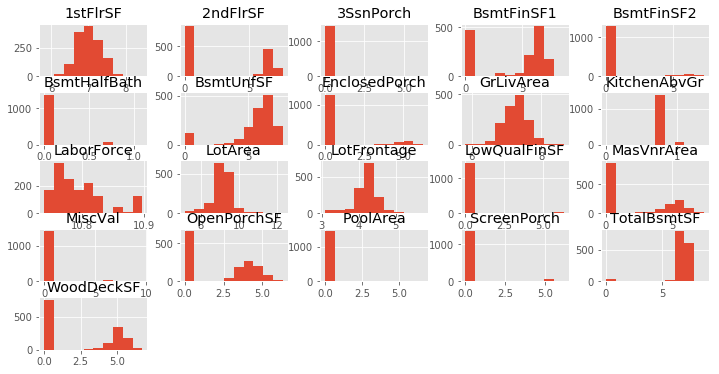

In [72]:
# Calculate skewenes
_ = df[sk_feat].hist()

For illistration, we plot the same scatter plots but using transformed living space variable.

Text(0.5,1,'Price')

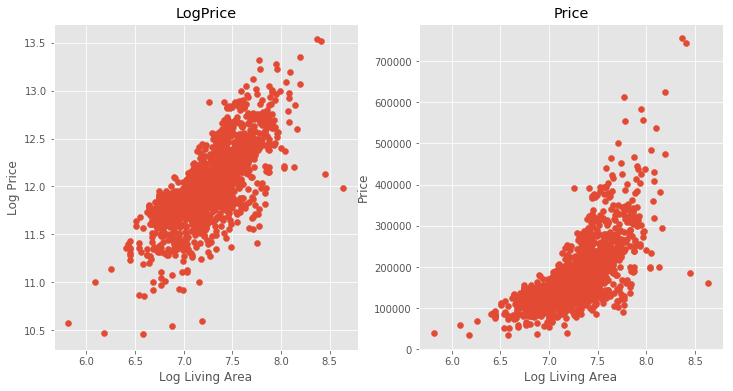

In [73]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df["SalePrice"], "log(price)":np.log(df["SalePrice"])})
prices = prices.join(pd.DataFrame({'LivingArea':df.GrLivArea}))

plt.subplot(1,2,1)
plt.scatter(prices['LivingArea'], prices['log(price)'])
plt.ylabel('Log Price')
plt.xlabel('Log Living Area')
plt.title('LogPrice')

plt.subplot(1,2,2)
plt.scatter(prices['LivingArea'], prices['price'])
plt.ylabel('Price')
plt.xlabel('Log Living Area')
plt.title('Price')

In [74]:
# Save skewed features list
pickle.dump(sk_feat, open('./tmp/sk_feat.list', 'wb'))

## Models fitted to the whole features set

First, we fit linear regression models to the whole dataset.

## Model 1: Linear regression on the whole set

In [75]:
data = df.copy()

# Create sets
X = data.copy().drop('SalePrice', axis=1)
y = np.log(data.copy()['SalePrice'])

X.shape

(1460, 278)

In [76]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 278)
X_test : (438, 278)
y_train : (1022,)
y_test : (438,)


We create helper functions to evaluate results

In [77]:
def rmse_cv(model, X, y):
    '''
    A helper function to calculate the cross validated RMSE
    '''
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

In [78]:
def rmsle(model, X, y):
    '''
    Calculates rmsle as set by Kaggle
    '''
    return (math.sqrt(np.mean((np.log10(np.exp(model.predict(X))) - np.log10(np.exp(y))) ** 2)))

### Model 1a: Ridge normalization

Lowest rmse:  0.12256241999425802
Optimal alpha:  [5.6]


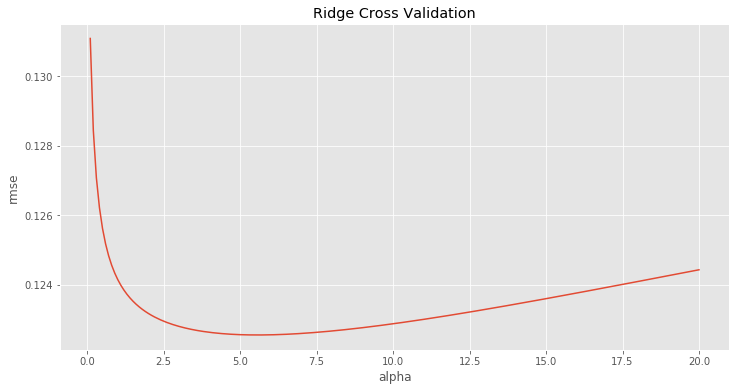

In [79]:

alphas = np.linspace(0.1,20,200)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train,y_train).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")


print('Lowest rmse: ',cv_ridge.min())
print('Optimal alpha: ', cv_ridge[cv_ridge==cv_ridge.min()].index.values)

alpha = cv_ridge[cv_ridge==cv_ridge.min()].index.values

Fit model to the new train dataset and compare with new test.

Model train accuracy (rmsle):  0.04295678514490409
Model test accuracy (rmsle):  0.06117987382373579


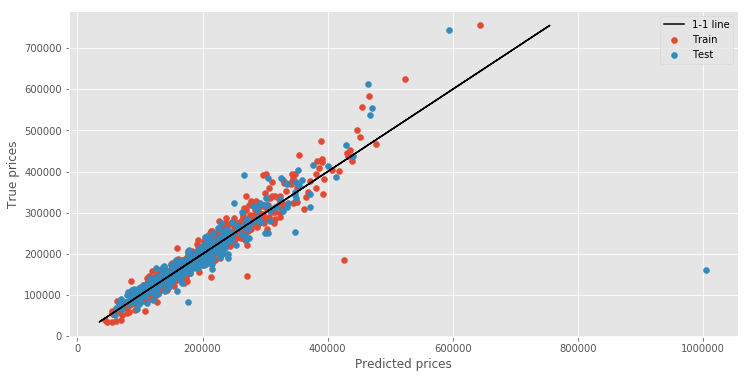

In [80]:
model_tmp = Ridge(alpha=alpha)
model_tmp = model_tmp.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


We train the model on the whole dataset

In [110]:
model1a = Ridge(alpha=alpha)
model1a.fit(X,y)

score1a = rmsle(model1a, X, y)

print('Model accuracy rmsle: ', rmsle(model1a, X, y))

Model accuracy rmsle:  0.03944024919997913


We plot regression coefficients

<BarContainer object of 20 artists>

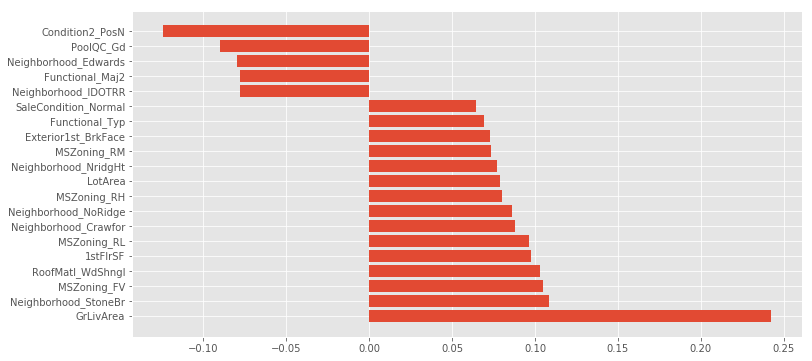

In [82]:
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model1a.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)

### Model 1b: LASSO regularization 

Alpha : 0.00015000000000000001
Model accuracy train : 0.12127743680254596
Model accuracy test: 0.14608193013631182


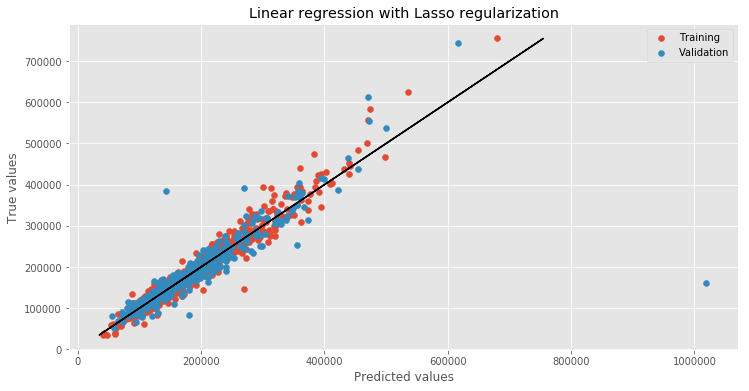

In [83]:
alphas = np.linspace(0.0001,1,20)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_


# Narrow down alpha
alphas = alpha * np.linspace(0.5, 1.5, 10)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)

# Fit the model
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Alpha :", alpha)

print("Model accuracy train :", rmse_cv(lasso, X_train, y_train).mean())
print("Model accuracy test:", rmse_cv(lasso, X_test, y_test).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


# Plot predictions
plt.scatter(np.exp(y_train_las), np.exp(y_train), label = "Training")
plt.scatter(np.exp(y_test_las), np.exp(y_test), label = "Validation")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.legend()
plt.plot(np.exp(y), np.exp(y), c = "black")
plt.savefig('./output/figX.png', dpi=300)
plt.show()




In [84]:
model1b = Lasso(alpha=alpha)
model1b.fit(X,y)

score1b =  rmsle(model1b, X, y)

print('Model accuracy rmsle: ', rmsle(model1b, X, y))

Model accuracy rmsle:  0.044143648556325174


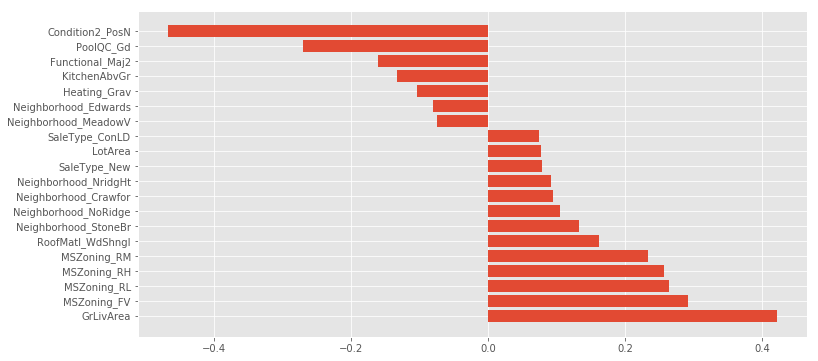

In [85]:
# Plot important coefficients
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model1b.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)
plt.savefig('./output/figX.png', dpi=300)
plt.show()


Train model on the whole dataset.

## Fitting the model on the selected features

The features that were selected in [Trees.ipynb](Trees.ipynb) are used to create regression models

In [86]:
# Load list of variables
select_var = pickle.load(open('./tmp/feaure_list_dt.list', 'rb'))

# Set new X
X_sel = X[select_var].copy()

### Model 2a: Ridge regularization

In [87]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 23)
X_test : (438, 23)
y_train : (1022,)
y_test : (438,)


Lowest rmse:  0.13795474417144676
Optimal alpha:  [1.]


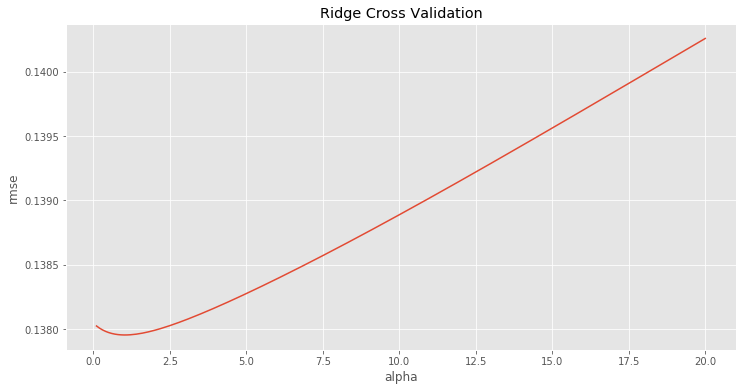

In [88]:

alphas = np.linspace(0.1,20,200)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train,y_train).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")


print('Lowest rmse: ',cv_ridge.min())
print('Optimal alpha: ', cv_ridge[cv_ridge==cv_ridge.min()].index.values)

alpha = cv_ridge[cv_ridge==cv_ridge.min()].index.values

Fit model to the new train dataset and compare with new test.

Model train accuracy (rmsle):  0.05906884662153706
Model test accuracy (rmsle):  0.06390929083976314


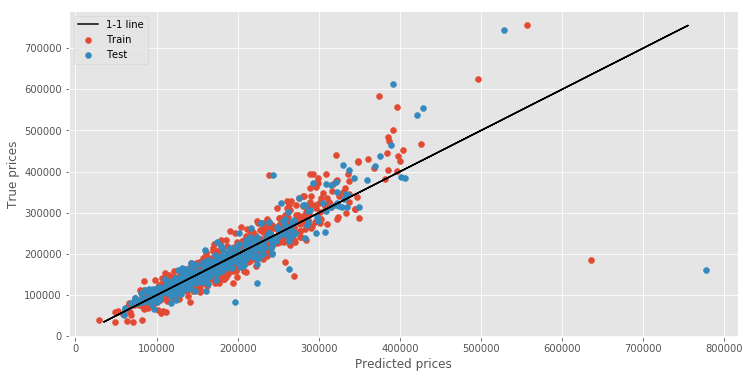

In [89]:
model_tmp = Ridge(alpha=alpha)
model_tmp = model_tmp.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test,y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


We train the model on the whole dataset

In [113]:
model2a = Ridge(alpha=alpha)
model2a.fit(X,y)

score2a = rmsle(model2a, X, y)

print('Model accuracy (rmsle): ', rmsle(model2a, X, y))

Model accuracy (rmsle):  0.03944024919997913


We plot regression coefficients

<BarContainer object of 20 artists>

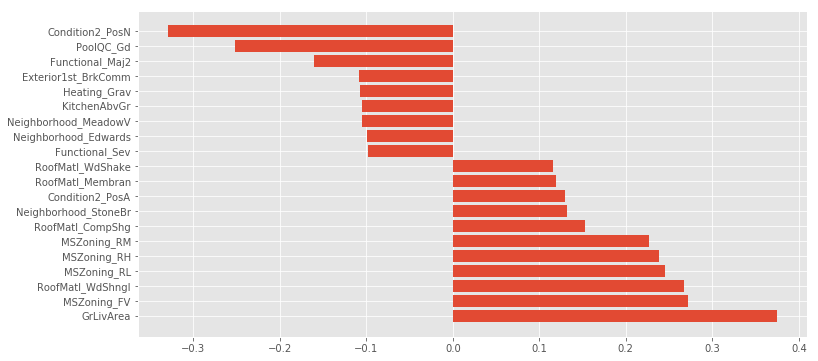

In [91]:
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model2a.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)

## Model 2b: LASSO regularization 

Alpha : 0.00015000000000000001
Model accuracy (rmse) train : 0.13801401904499072
Model accuracy (rmse) test: 0.14505208039916295


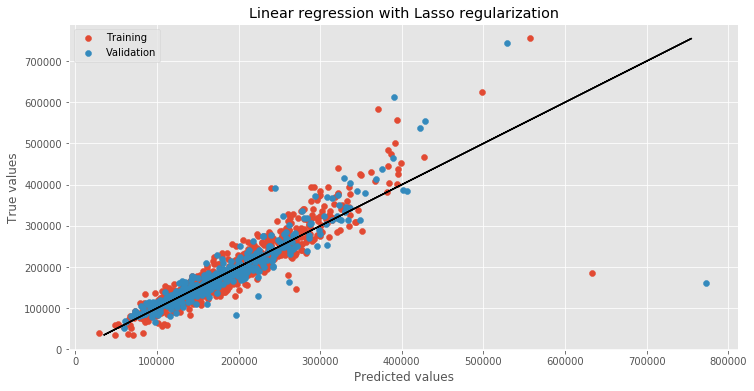

In [92]:
alphas = np.linspace(0.0001,1,20)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_


# Narrow down alpha
alphas = alpha * np.linspace(0.5, 1.5, 10)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)

# Fit the model
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Alpha :", alpha)

print("Model accuracy (rmse) train :", rmse_cv(lasso, X_train, y_train).mean())
print("Model accuracy (rmse) test:", rmse_cv(lasso, X_test, y_test).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


# Plot predictions
plt.scatter(np.exp(y_train_las), np.exp(y_train), label = "Training")
plt.scatter(np.exp(y_test_las), np.exp(y_test), label = "Validation")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.legend()
plt.plot(np.exp(y), np.exp(y), c = "black")
plt.savefig('./output/figX.png', dpi=300)
plt.show()




In [116]:
model2b = Lasso(alpha=alpha)
model2b.fit(X,y)

score2b = rmsle(model2b, X, y)

print('Model accuracy (rmsle): ', rmsle(model2b, X, y))

Model accuracy (rmsle):  0.044143648556325174


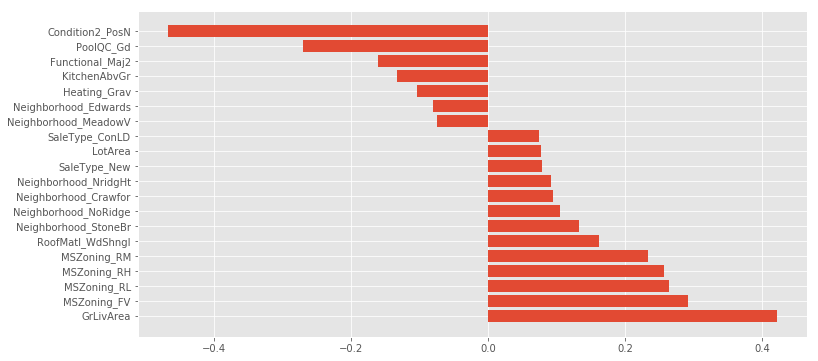

In [94]:
# Plot important coefficients
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model2b.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)
plt.savefig('./output/figX.png', dpi=300)
plt.show()


## PCA models

We perform a principal component analysis and fit regressions to principal components.

In [148]:
data = df.copy()

X = data.copy().drop('SalePrice', axis=1)
y = np.log(data.copy()['SalePrice'])
print(X.shape)

# Cross validate PCA
n_folds = 10
n_sim = 10
n_comp = np.linspace(1,100,100, dtype=int)

result = np.zeros(len(n_comp)*2).reshape(len(n_comp),2)

# Perform naive cross-validation
for n, comp in enumerate(n_comp):
    train = 0.0
    test = 0.0            
    for i in range(0,n_sim):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/n_folds)
        pca = decomposition.PCA(n_components=comp)
        pca.fit(X_train)
        transformed_train = pca.transform(X_train)
        model_tmp= LinearRegression()
        
        score_train = model_tmp.fit(transformed_train, y_train)
        score_train = score_train.score(transformed_train, y_train)
        train += score_train

        transformed_test = pca.transform(X_test)
        score_test = model_tmp.fit(transformed_test, y_test)
        score_test = score_test.score(transformed_test, y_test)
        test += score_test

    result[n,0]= train/n_sim
    result[n,1] = test/n_sim



(1460, 278)


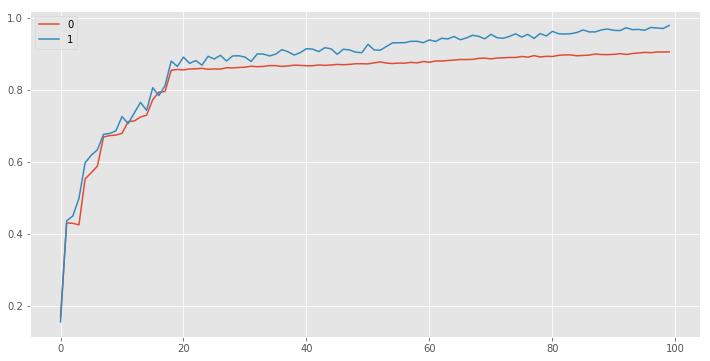

In [149]:
pd.DataFrame(result).plot()

In [152]:
pd.DataFrame(result, columns=['train', 'test']).head(30)

,train,test
0,0.167917,0.154114
1,0.429836,0.435664
2,0.428963,0.449325
3,0.424687,0.498556
4,0.552675,0.597765
5,0.569893,0.618527
6,0.588350,0.633859
7,0.669480,0.676703
8,0.673279,0.679346
9,0.674645,0.686282


We keep four principal components

In [153]:

pca = decomposition.PCA(n_components=18)
pca.fit(X)
transformed = pca.transform(X)

explained_variance = np.var(transformed, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Find how may components explain 98% of variance
expl = np.cumsum(explained_variance_ratio)
expl


array([0.80889574, 0.91491127, 0.99046015, 0.99592044, 0.99896522,
       0.99978377, 0.99983338, 0.99986586, 0.99989142, 0.99991318,
       0.99993434, 0.99994908, 0.99996132, 0.99997193, 0.99998114,
       0.99998785, 0.9999943 , 1.        ])

In [154]:
X_pca = pd.DataFrame(transformed)
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-151.077497,33.990785,11.419708,-13.595851,-31.602740,1.046437,2.632695,-3.198411,5.107514,-3.345667,-1.338969,0.784563,0.143547,0.857074,0.522301,-0.471731,0.450351,-0.038662
1,-98.886244,-37.697471,-118.576509,-55.943201,-5.192885,-9.039281,-3.470208,-0.731865,0.080950,3.711888,1.110006,-1.214165,-2.489011,-0.194466,-0.954406,0.318505,0.557540,-0.069450
2,-166.743231,91.004768,22.237556,-14.870169,-24.553855,0.840884,2.716601,-2.696636,-1.765415,-3.488966,-3.058694,0.875106,-0.675555,0.336093,0.623415,-1.455533,-0.872933,0.115984
3,-172.664709,129.375461,-178.467617,34.056252,71.312601,14.787435,1.524049,-1.579475,5.907867,-0.564114,-1.076984,-2.464883,-0.094840,0.231868,3.704180,0.800392,-0.598018,-0.416001
4,-232.954252,306.161124,77.350624,68.273711,0.885888,-1.415824,3.584825,-4.593454,-4.444762,-0.423290,-0.157606,0.067484,-0.715828,0.246398,0.515777,-0.391912,0.378438,-0.039928


### Model 3: Multiple Linear Regression

In [155]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 18)
X_test : (438, 18)
y_train : (1022,)
y_test : (438,)


Model train accuracy (mrsle):  0.07883067440676551
Model test accuracy (mrsle):  0.07970243692651262


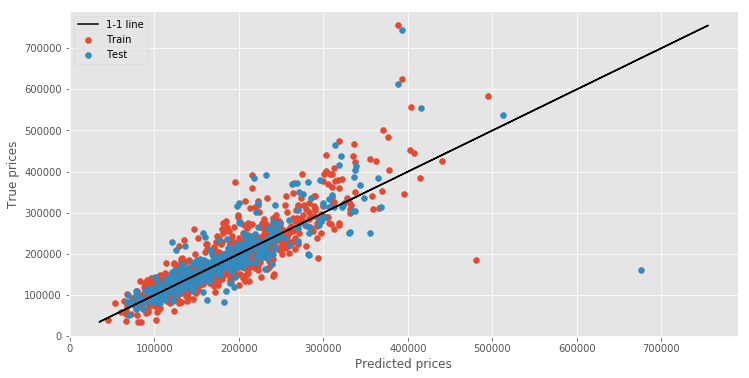

In [156]:

model_tmp= LinearRegression()
model_tmp = model_tmp.fit(X_train, y_train)


print('Model train accuracy (mrsle): ', rmsle(model_tmp, X_train,y_train))
print('Model test accuracy (mrsle): ', rmsle(model_tmp, X_test,y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_  = plt.legend()

Fit to the whole dataset

In [157]:
model3= LinearRegression()

model3.fit(X_pca, y)

score3 = rmsle(model3, X_pca, y)

print('Model accuracy (rmsle): ', rmsle(model3, X_pca, y))


Model accuracy (rmsle):  0.07884016921576155


## Combine the models

We combine the models and pickle them for use on the train set

In [158]:
# Models

models = ['model1a', 'model1b', 'model2a', 'model2b', 'model3']
scores = [score1a, score1b, score2a, score2b, score3]

models_comb = pd.DataFrame({'model':models, 'score': scores})
print(models_comb)

# Pickle
pickle.dump(models_comb, open('./tmp/models_comb', 'wb'))

     model     score
0  model1a  0.039440
1  model1b  0.044144
2  model2a  0.039440
3  model2b  0.044144
4   model3  0.078840


Pickle models

In [159]:
models_obj = [model1a, model1b, model2a, model2b, model3]

for i, model in enumerate(models_obj):
    name = './tmp/'+models[i]+'.model'
    pickle.dump(model, open(name, 'wb'))
